In [1]:
import os
import numpy as np
import pandas as pd
from biom import load_table
from sklearn.ensemble import RandomForestClassifier
from assets.classification import (mcnemar_test,
                                   roc_multiclass,
                                   khatri_rao,
                                   roc_binary)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.style.use('ggplot')
%matplotlib inline

#### tables and metadata

In [20]:
# import each table
microbiome_table = load_table('../data/microbiome-cleaned.biom')
metadata_one = pd.read_csv('../data/microbiome-cleaned.tsv', sep='\t', index_col=0)
    
fecal_metab_table = load_table('../data/metabolite-cleaned.biom')
metadata_two = pd.read_csv('../data/metabolite-cleaned.tsv', sep='\t', index_col=0)

plasma_metab_table = load_table('../data/plasma-metabolite-cleaned.biom')
metadata_three = pd.read_csv('../data/plasma-metabolite-cleaned.tsv', sep='\t', index_col=0)

# plasma (needs to be matched)
map_ids = {v.replace('FD','PD'):k for k, v in metadata_two.filename.to_dict().items()}
metadata_three['sample_id'] = [map_ids[x] if x in map_ids.keys() else np.nan for x in metadata_three.filename]
metadata_three = metadata_three.dropna(subset=['sample_id'])
metadata_three['prev_index'] = metadata_three.index
metadata_three = metadata_three.set_index('sample_id')   
plasma_relabel = {v:k for k, v in metadata_three['prev_index'].to_dict().items()}
plasma_metab_table = plasma_metab_table.filter(plasma_relabel.keys())
plasma_metab_table = plasma_metab_table.update_ids(plasma_relabel)
 
# diet data (use zero instead of -14)
diet_id_map = {v:k for k, v in metadata_one.StudyID.to_dict().items()}
diet_data = pd.read_csv('../data/diet_score_17patients_updated_febr2022.csv', index_col=0)
diet_data = diet_data[['1002' not in x for x in diet_data.index]]
diet_data = diet_data.loc[['T1' not in x for x in diet_data.index], :]
diet_data.index = [x.replace('T2','T1') for x in diet_data.index]
diet_data = diet_data.reindex(set(diet_data.index) & set(diet_id_map.keys()))
diet_data.index = [diet_id_map[x] for x in diet_data.index]
diet_data = diet_data.drop(['id','Patient','Time','diet','Study ID'], axis=1)
diet_data = diet_data.replace('higher_delta', 1).replace('lower_delta', 0).replace('higher', 1).replace('lower', 0)

# match all  
shared_all = set(metadata_one.index) & set(metadata_two.index) & set(metadata_three.index)  & set(diet_data.index)
metadata = metadata_one.copy().reindex(shared_all)
# filter/match tables
microbiome_table = microbiome_table.filter(metadata.index)
fecal_metab_table = fecal_metab_table.filter(metadata.index)
plasma_metab_table = plasma_metab_table.filter(metadata.index)
# ensure no zero counts
microbiome_table = microbiome_table.filter(microbiome_table.ids('observation')[microbiome_table.sum('observation') > 0], axis='observation')
fecal_metab_table = fecal_metab_table.filter(fecal_metab_table.ids('observation')[fecal_metab_table.sum('observation') > 0], axis='observation')
plasma_metab_table = plasma_metab_table.filter(plasma_metab_table.ids('observation')[plasma_metab_table.sum('observation') > 0], axis='observation')
# to matched dataframe
microbiome_table_df = pd.DataFrame(microbiome_table.matrix_data.toarray(),
                                   microbiome_table.ids('observation'),
                                   microbiome_table.ids()).T.reindex(metadata.index)
fecal_metab_table_df = pd.DataFrame(fecal_metab_table.matrix_data.toarray(),
                                   fecal_metab_table.ids('observation'),
                                   fecal_metab_table.ids()).T.reindex(metadata.index)
plasma_metab_table_df = pd.DataFrame(plasma_metab_table.matrix_data.toarray(),
                                   plasma_metab_table.ids('observation'),
                                   plasma_metab_table.ids()).T.reindex(metadata.index)
diet_data = diet_data.reindex(metadata.index)

# split b4/after
metadata_before = metadata[metadata.timepoint_verbose.isin(['day-14'])]
metadata_after = metadata[metadata.timepoint_verbose.isin(['day+14'])]

diet_data_before = diet_data.reindex(metadata_before.index).fillna(0)
diet_data_after = diet_data.reindex(metadata_after.index).fillna(0)

microbiome_table_df_before = microbiome_table_df.reindex(metadata_before.index)
microbiome_table_df_after = microbiome_table_df.reindex(metadata_after.index)
microbiome_table_df_before = microbiome_table_df_before.loc[:, microbiome_table_df_before.sum(0) > 10]
microbiome_table_df_after = microbiome_table_df_after.loc[:, microbiome_table_df_after.sum(0) > 10]

fecal_metab_table_df_before = fecal_metab_table_df.reindex(metadata_before.index)
fecal_metab_table_df_after = fecal_metab_table_df.reindex(metadata_after.index)
fecal_metab_table_df_before = fecal_metab_table_df_before.loc[:, fecal_metab_table_df_before.sum(0) > 10]
fecal_metab_table_df_after = fecal_metab_table_df_after.loc[:, fecal_metab_table_df_after.sum(0) > 10]

plasma_metab_table_df_before = plasma_metab_table_df.reindex(metadata_before.index)
plasma_metab_table_df_after = plasma_metab_table_df.reindex(metadata_after.index)
plasma_metab_table_df_before = plasma_metab_table_df_before.loc[:, plasma_metab_table_df_before.sum(0) > 10]
plasma_metab_table_df_after = plasma_metab_table_df_after.loc[:, plasma_metab_table_df_after.sum(0) > 10]

all_before = pd.concat([microbiome_table_df_before, fecal_metab_table_df_before, plasma_metab_table_df_before, diet_data_before], axis=1)
all_after = pd.concat([microbiome_table_df_after, fecal_metab_table_df_after, plasma_metab_table_df_after, diet_data_after], axis=1)


In [21]:
metadata_before.Pain_50_improvement.value_counts()


no_response    8
response       4
Name: Pain_50_improvement, dtype: int64

In [22]:
metadata_after.Pain_50_improvement.value_counts()


no_response    8
response       5
Name: Pain_50_improvement, dtype: int64

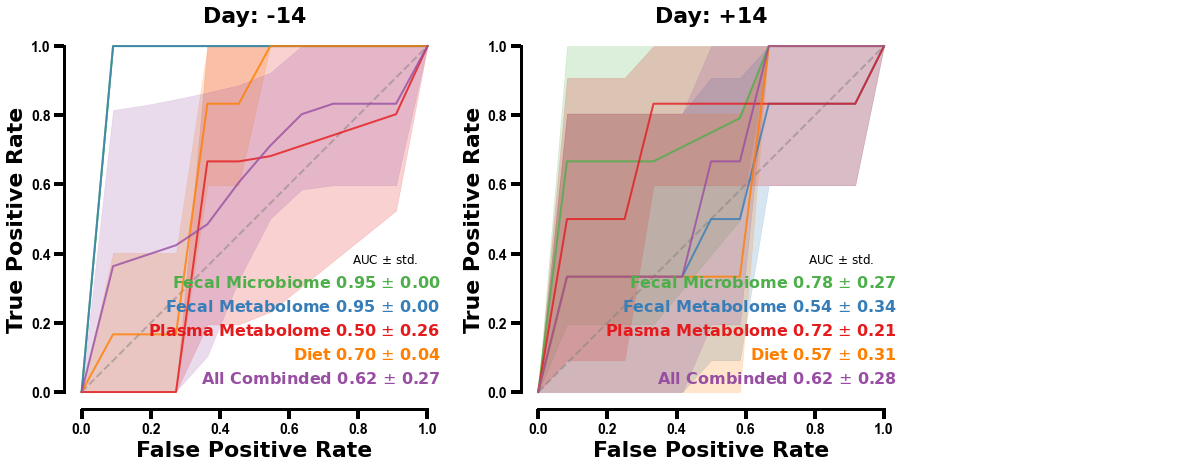

In [23]:

stats = {}

col_learn = 'Pain_50_improvement'
number_of_splits_both = [3, 3, 3]
classifier = RandomForestClassifier(n_jobs=4, random_state=0)

Xdfs = [[microbiome_table_df_before, fecal_metab_table_df_before, plasma_metab_table_df_before, diet_data_before, all_before],
        [microbiome_table_df_after, fecal_metab_table_df_after, plasma_metab_table_df_after, diet_data_after, all_after]]
ydfs = [metadata_before, metadata_after]
titles = ['Day: -14','Day: +14']
labels = [['Fecal Microbiome','Fecal Metabolome','Plasma Metabolome','Diet', 'All Combinded'],
          ['Fecal Microbiome','Fecal Metabolome', 'Plasma Metabolome','Diet', 'All Combinded']]
color_maps = [['#4daf4a', '#377eb8', '#e41a1c', '#ff7f00','#984ea3'],
              ['#4daf4a', '#377eb8', '#e41a1c', '#ff7f00','#984ea3']]
          
fig, axn = plt.subplots(1, 2, figsize=(15, 7))

for Xdfs_tmp, ydf, title, ns, lbl, cmap, ax in zip(Xdfs, ydfs, titles,
                                                      number_of_splits_both,
                                                      labels,
                                                      color_maps,
                                                      axn.flatten()):
    
    ax, contingencys = roc_binary(Xdfs_tmp,
                                  ydf[col_learn],
                                  classifier,
                                  lbl,
                                  cmap,
                                  ns, ax)
    ax.set_title(title, fontsize=22, weight='bold', color='black')
    stats[title] = mcnemar_test(contingencys)

# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# save the figure to file
plt.savefig('../results/tables-figures/rev-figure-rf.pdf',
            dpi=600, 
            bbox_inches='tight',
            edgecolor='none')


plt.show()



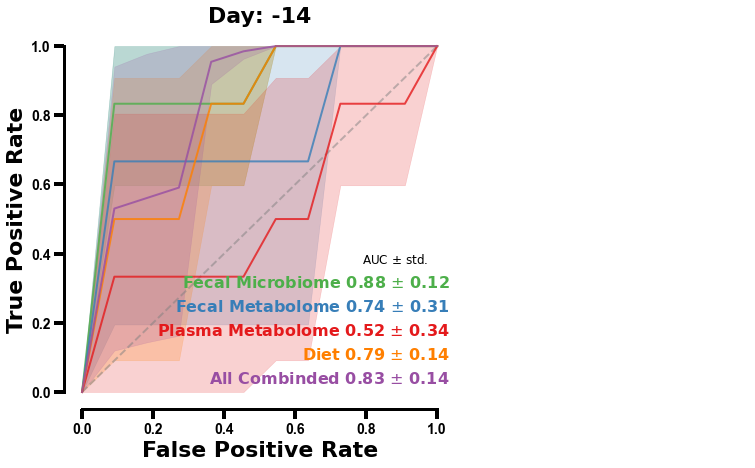

In [27]:

stats = {}

col_learn = 'Pain_50_improvement'
number_of_splits_both = [3, 3, 3]
classifier = RandomForestClassifier(n_jobs=4, random_state=42)

Xdfs = [[microbiome_table_df_before, fecal_metab_table_df_before, plasma_metab_table_df_before, diet_data_before, all_before]]
ydfs = [metadata_before]
titles = ['Day: -14']
labels = [['Fecal Microbiome','Fecal Metabolome','Plasma Metabolome', 'Diet', 'All Combinded']]
color_maps = [['#4daf4a', '#377eb8', '#e41a1c', '#ff7f00','#984ea3']]
          
fig, axn = plt.subplots(1, 1, figsize=(7, 7))

for Xdfs_tmp, ydf, title, ns, lbl, cmap, ax in zip(Xdfs, ydfs, titles,
                                                      number_of_splits_both,
                                                      labels,
                                                      color_maps,
                                                      [axn]):
    
    ax, contingencys = roc_binary(Xdfs_tmp,
                                  ydf[col_learn],
                                  classifier,
                                  lbl,
                                  cmap,
                                  ns, ax)
    ax.set_title(title, fontsize=22, weight='bold', color='black')
    stats[title] = mcnemar_test(contingencys)

# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# save the figure to file
plt.savefig('../results/tables-figures/rev-figure-rf-before-only.pdf',
            dpi=600, 
            bbox_inches='tight',
            edgecolor='none')


plt.show()
